## Business Question

Predcit the value of my current properties using recently sold houses in San Francisco. Based on this value, figure out how much my listing price should be if I want to sell them.

In [208]:
import time
import os
import itertools
from random import randint
from time import sleep
import requests
from bs4 import BeautifulSoup

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [121]:
import pylab
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import diagnostic_plots
from statsmodels.graphics.gofplots import ProbPlot
from scipy import stats
from statsmodels.stats import diagnostic

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, SGDRegressor
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing, tree, ensemble
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import learning_curve


import warnings
warnings.filterwarnings('ignore')

In [209]:
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

In [ ]:
driver.close()

## Get the links

In [ ]:
driver.get('https://www.zillow.com/homes/recently_sold/San-Francisco-CA/20330_rid/globalrelevanceex_sort/37.966666,-122.188225,37.581861,-122.681236_rect/10_zm/')

In [ ]:
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [ ]:
# Get the links of every sold house on the first page
listofhouses = soup.find_all('div', class_='zsg-photo-card-content zsg-aspect-ratio-content')

first_page_urls = []
halfofurl = 'https://www.zillow.com/'
for item in listofhouses:
    url = item.find('a').get('href')
    first_page_urls.append(halfofurl+url)

In [ ]:
pages = np.arange(2, 21)
url_pages = ['https://www.zillow.com/homes/recently_sold/0_singlestory/37.833582,-122.43104,37.737395,-122.554293_rect/12_zm/{}_p/'.format(page) for page in pages]

In [ ]:
# Get the rest of the links on other pages
def get_links(url_pages):
    halfofurl = 'https://www.zillow.com/'
    the_rest_urls = []
    for url in url_pages:
        driver.get(url)
        sleep(randint(10,20)) # change to shorter period
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        listofhouses = soup.find_all('div', class_='zsg-photo-card-content zsg-aspect-ratio-content')
        for item in listofhouses:
            url = item.find('a').get('href')
            the_rest_urls.append(halfofurl+url)
    return the_rest_urls

In [ ]:
links = get_links(url_pages)

In [ ]:
all_links = first_page_urls + links

## Get the data from the links

In [ ]:
driver.get('https://www.zillow.com//homedetails/225-Bay-St-APT-203-San-Francisco-CA-94133/2089603231_zpid/')

In [ ]:
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [ ]:
house = []

In [ ]:
def get_data(all_links):
    house = []
    for url in all_links:
        driver.get(url)
        sleep(randint(2,3))
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        # Get address for one item
        addr = soup.find('h1', class_='notranslate').getText()
        house.append(addr)
        # Get beds, baths, sqft for one item
        beds = soup.find_all('span', class_='addr_bbs')
        house.extend([b.getText() for b in beds])
        # Get sold price, sold date, and Zestimate for one item
        price_div = soup.find_all('div', class_='main-row status-icon-row recently-sold-row home-summary-row')[0]
        price_span = price_div.find('span', class_='').getText()
        house.append(price_span)
        # Get sold date for one item
        date_div = soup.find_all('div', class_='home-summary-row')[1]
        date_span = date_div.find('span', class_='').getText()
        house.append(date_span)
        # Get type, year built, heating, cooling, parking, and lot
        features = soup.find_all('div', class_='hdp-fact-ataglance-value')
        house.extend([f.getText() for f in features])
    return house

## Zillow

In [3]:
df = pd.read_csv('zillow.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df = (pd.DataFrame(np.reshape(df.values,(440,12)),columns=['Address','Beds','Baths','Sqft','Price_Sold','Date_Sold','Type','Year_Built','Heating','Cooling','Parking','Lot&HOA']))

In [5]:
# Make some changes for merging
df[df == 'No Data'] = np.nan
df['Zipcode'] = [add[-6:] for add in df.Address]
df['Address'] = [add[:-11] for add in df.Address]
df['Beds'] = [bed[0] for bed in df.Beds]
df['Baths'] = [bath[:-5] for bath in df.Baths]
df['Sqft'] = [sqft[:-5].replace(',', '') for sqft in df.Sqft]
df['Price_Sold'] = [sold.strip().replace('$', '').replace(',', '') for sold in df.Price_Sold]
df['Date_Sold'] = [dt.datetime.strptime(date.strip(), '%m/%d/%y') for date in df.Date_Sold]
df['HOA'] = [lot.replace('$', '').replace('/month', '') if '$' in str(lot) else np.nan for lot in df['Lot&HOA']]
df['Lot'] = [str(lot)[:-5].replace(',', '') if '$' not in str(lot) else np.nan for lot in df['Lot&HOA']]
df.drop('Lot&HOA', axis=1, inplace=True)

In [6]:
df = df[(df.Beds != 'S') & (df.Beds != '-') & (df.Beds != '--') & (df.Sqft != '--')]

In [7]:
#Drop lot first bcuz too many na
df.drop('Lot', axis=1, inplace=True)

In [765]:
df.head()

,Address,Beds,Baths,Sqft,Price_Sold,Date_Sold,Type,Year_Built,Heating,Cooling,Parking,Zipcode,HOA
0,"182 32nd Ave, San Francisco",5,3.5,4700,6750000,2018-07-11,Single Family,1916,Forced air,None,2 spaces,94121,NaN
1,"3981 Alemany Blvd APT 219, San Francisco",2,2,968,800000,2018-07-10,Condo,2002,Forced air,Central,NaN,94132,497
2,"225 Bay St APT 203, San Francisco",2,2,850,930000,2018-07-10,Condo,1979,NaN,NaN,NaN,94133,448
3,"1542 24th Ave, San Francisco",2,1,1500,1575000,2018-07-10,Single Family,1939,Other,Central,2 spaces,94122,NaN
4,"1846 43rd Ave, San Francisco",3,1,1214,1159900,2018-07-10,Single Family,1945,Forced air,Central,NaN,94122,NaN


## Redfin

In [8]:
df_R = pd.read_csv('redfin.csv')

In [9]:
df_R = df_R[['SOLD DATE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'ZIP', 'PRICE', 'BEDS', 'BATHS', 'SQUARE FEET', 'YEAR BUILT', 'HOA/MONTH']]

In [10]:
df_R.columns = ['Date_Sold','Type','Address', 'CITY','Zipcode','Price_Sold','Beds','Baths','Sqft','Year_Built', 'HOA']
df_R['Address'] = df_R[['Address', 'CITY']] .apply(lambda x: ', '.join(x), axis=1)
df_R.drop('CITY', axis=1, inplace=True)

In [11]:
df_R = df_R[df_R.Zipcode != '94121-3267']

In [770]:
df_R.head()

,Date_Sold,Type,Address,Zipcode,Price_Sold,Beds,Baths,Sqft,Year_Built,HOA
0,June-28-2018,Condo/Co-op,"932 Kirkham St, San Francisco",94122,1375000.0,2.0,1.0,1150.0,1946.0,300.0
1,July-13-2018,Condo/Co-op,"855 Folsom St #126, San Francisco",94107,870000.0,1.0,1.5,847.0,2001.0,554.0
2,June-20-2018,Single Family Residential,"3060 26th St, San Francisco",94110,1615000.0,3.0,1.5,1930.0,1931.0,NaN
3,June-26-2018,Single Family Residential,"760 Felton St, San Francisco",94134,1410000.0,3.0,1.0,1580.0,1938.0,NaN
4,July-2-2018,Single Family Residential,"2598 Diamond St, San Francisco",94131,1650000.0,3.0,2.0,1390.0,1924.0,NaN


## Cleaning

In [12]:
new_df = pd.concat([df, df_R])

In [171]:
new_df.describe()

,Baths,Beds,Cooling,HOA,Heating,Parking,Price_Sold,Sqft,Year_Built,Type_Condo,...,Zipcode_94121,Zipcode_94122,Zipcode_94123,Zipcode_94124,Zipcode_94127,Zipcode_94131,Zipcode_94132,Zipcode_94133,Zipcode_94134,Zipcode_94158
count,612.000000,612.000000,612.000000,612.000000,612.00000,612.000000,6.120000e+02,612.000000,612.000000,612.000000,...,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000
mean,2.064869,2.630719,0.245098,0.408497,0.28268,0.408497,1.918583e+06,1719.089869,1942.486928,0.303922,...,0.083333,0.102941,0.070261,0.003268,0.013072,0.052288,0.017974,0.008170,0.014706,0.004902
std,1.082021,1.268105,0.430497,0.491958,0.45067,0.491958,1.433489e+06,1035.762788,38.504679,0.460325,...,0.276611,0.304131,0.255796,0.057119,0.113676,0.222788,0.132965,0.090091,0.120471,0.069899
min,0.750000,0.000000,0.000000,0.000000,0.00000,0.000000,1.585000e+05,434.000000,1876.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.149750e+06,1058.750000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.558000e+06,1449.000000,1929.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.812500,3.000000,0.000000,1.000000,1.00000,1.000000,2.179000e+06,2030.250000,1979.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.500000,9.000000,1.000000,1.000000,1.00000,1.000000,1.400000e+07,9074.000000,2018.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Fill NAs 
new_df[['Heating', 'Cooling', 'Parking', 'HOA']] = new_df[['Heating', 'Cooling', 'Parking', 'HOA']].fillna(value=0)
# Change to 0 or 1
new_df[['Heating', 'Cooling', 'Parking', 'HOA']] = new_df[['Heating', 'Cooling', 'Parking', 'HOA']].where(new_df[['Heating', 'Cooling', 'Parking', 'HOA']] == 0, 1)
# Drop NAs
new_df.dropna(inplace=True)

In [15]:
# Change to numeric
to_num = ['Beds', 'Baths', 'Sqft', 'Price_Sold', 'Year_Built', 'Zipcode', 'HOA', 'Heating', 'Cooling', 'Parking', 'HOA']
new_df[to_num] = new_df[to_num].apply(pd.to_numeric)

In [16]:
# Get dummy on Type and Zipcode
new_df = pd.get_dummies(new_df, columns=['Type', 'Zipcode'], drop_first=True)

In [18]:
new_df.columns = ['Address', 'Baths', 'Beds', 'Cooling', 'Date_Sold', 'HOA', 'Heating', 'Parking', 'Price_Sold', 'Sqft', 'Year_Built', 'Type_Condo', 'Type_Condo_Co_op', 'Type_Multi_Family', 'Type_Multi_Family_2_4_Unit', 'Type_Single_Family', 'Type_Single_Family_Residential', 'Type_Townhouse', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105', 'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115', 'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121', 'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127', 'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134', 'Zipcode_94158']

## EDA

In [19]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 349
Data columns (total 41 columns):
Address                           612 non-null object
Baths                             612 non-null float64
Beds                              612 non-null float64
Cooling                           612 non-null int64
Date_Sold                         612 non-null object
HOA                               612 non-null int64
Heating                           612 non-null int64
Parking                           612 non-null int64
Price_Sold                        612 non-null float64
Sqft                              612 non-null float64
Year_Built                        612 non-null float64
Type_Condo                        612 non-null uint8
Type_Condo_Co_op                  612 non-null uint8
Type_Multi_Family                 612 non-null uint8
Type_Multi_Family_2_4_Unit        612 non-null uint8
Type_Single_Family                612 non-null uint8
Type_Single_Family_Residential    6

In [20]:
new_df.describe()

,Baths,Beds,Cooling,HOA,Heating,Parking,Price_Sold,Sqft,Year_Built,Type_Condo,...,Zipcode_94121,Zipcode_94122,Zipcode_94123,Zipcode_94124,Zipcode_94127,Zipcode_94131,Zipcode_94132,Zipcode_94133,Zipcode_94134,Zipcode_94158
count,612.000000,612.000000,612.000000,612.000000,612.00000,612.000000,6.120000e+02,612.000000,612.000000,612.000000,...,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000
mean,2.064869,2.630719,0.245098,0.408497,0.28268,0.408497,1.918583e+06,1719.089869,1942.486928,0.303922,...,0.083333,0.102941,0.070261,0.003268,0.013072,0.052288,0.017974,0.008170,0.014706,0.004902
std,1.082021,1.268105,0.430497,0.491958,0.45067,0.491958,1.433489e+06,1035.762788,38.504679,0.460325,...,0.276611,0.304131,0.255796,0.057119,0.113676,0.222788,0.132965,0.090091,0.120471,0.069899
min,0.750000,0.000000,0.000000,0.000000,0.00000,0.000000,1.585000e+05,434.000000,1876.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.149750e+06,1058.750000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.558000e+06,1449.000000,1929.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.812500,3.000000,0.000000,1.000000,1.00000,1.000000,2.179000e+06,2030.250000,1979.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.500000,9.000000,1.000000,1.000000,1.00000,1.000000,1.400000e+07,9074.000000,2018.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


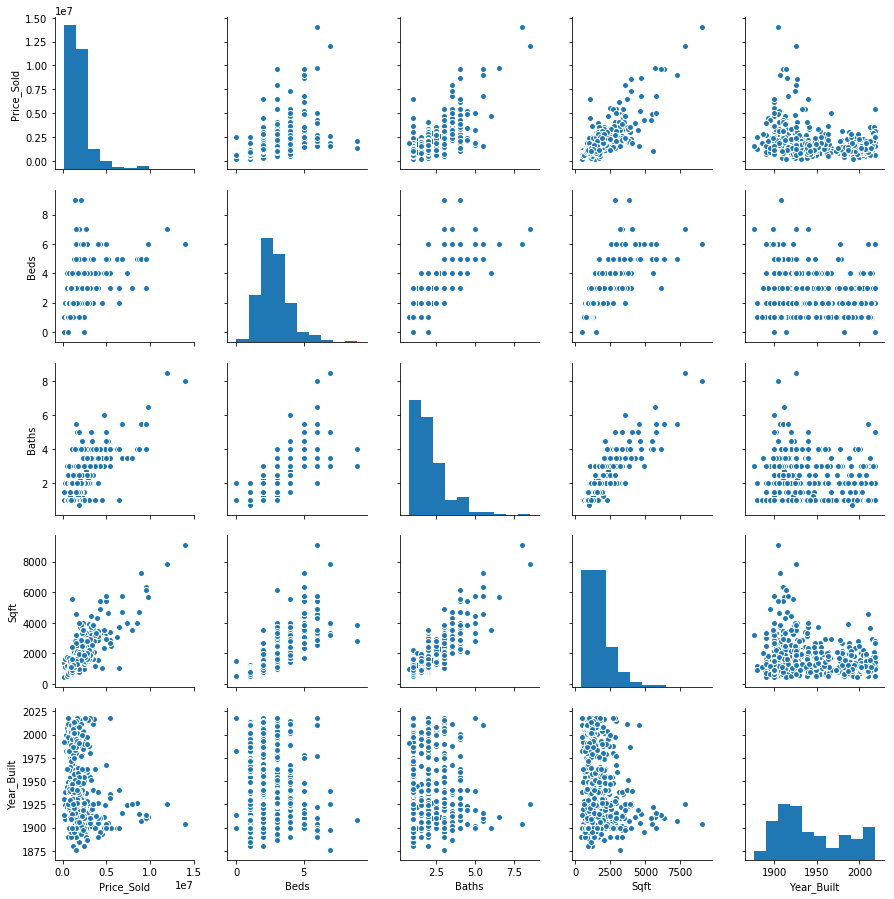

In [21]:
sns.pairplot(new_df[['Price_Sold', 'Beds', 'Baths', 'Sqft', 'Year_Built']]);

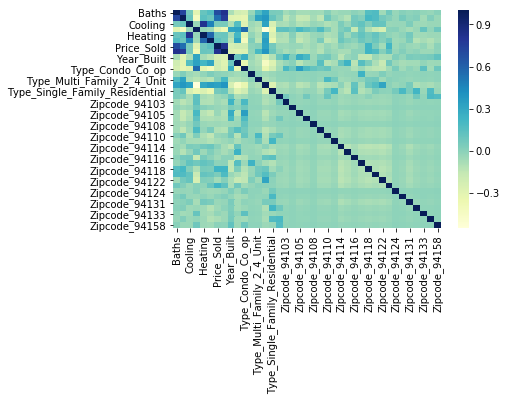

In [22]:
sns.heatmap(new_df.corr(), cmap='YlGnBu')

## OLS - Baseline Model

In [111]:
X = new_df[['Baths', 'Beds', 'Cooling', 'HOA', 'Heating', 'Parking', 'Sqft', 'Year_Built', 'Type_Condo', 'Type_Condo_Co_op', 'Type_Multi_Family', 'Type_Multi_Family_2_4_Unit','Type_Single_Family', 'Type_Single_Family_Residential', 'Type_Townhouse', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105', 'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115', 'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121', 'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127', 'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134', 'Zipcode_94158']]
y = new_df['Price_Sold']

In [24]:
# VIF
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif.sort_values(by='VIF Factor')

,VIF Factor,Features
19,1.169943,Zipcode_94108
31,1.180696,Zipcode_94124
16,1.258217,Zipcode_94104
37,1.290384,Zipcode_94158
35,1.423063,Zipcode_94133
32,1.808571,Zipcode_94127
22,1.892449,Zipcode_94112
36,1.907800,Zipcode_94134
34,2.060489,Zipcode_94132
18,2.123446,Zipcode_94107


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [187]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [114]:
lsm = smf.ols('Price_Sold ~ Beds + Baths + Sqft + Year_Built + Heating + Cooling + Parking + HOA + Type_Condo + Type_Condo_Co_op + Type_Multi_Family + Type_Multi_Family_2_4_Unit + Type_Single_Family + Type_Single_Family_Residential + Type_Townhouse + Zipcode_94103 + Zipcode_94104 + Zipcode_94105 + Zipcode_94107 + Zipcode_94108 + Zipcode_94109 + Zipcode_94110 + Zipcode_94112 + Zipcode_94114 + Zipcode_94115 + Zipcode_94116 + Zipcode_94117 + Zipcode_94118 + Zipcode_94121 + Zipcode_94122 + Zipcode_94123 + Zipcode_94124 + Zipcode_94127 + Zipcode_94131 + Zipcode_94132 + Zipcode_94133 + Zipcode_94134 + Zipcode_94158', data=train_df)
fit_base = lsm.fit()
fit_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price_Sold   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     35.81
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          3.23e-108
Time:                        12:02:53   Log-Likelihood:                -6855.3
No. Observations:                 459   AIC:                         1.379e+04
Df Residuals:                     420   BIC:                         1.395e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       3.327e+06   2.49e+06      1.335      0.183   -1.57e+06    8.23e+06
Beds                           -1.797e+05   5.38e+04     -3.340      0.001   -2.86e+05    -7.4e+04
Baths                           1.755e+05   6.86e+04      2.557      0.011    4.06e+04     3.1e+05
Sqft                            1115.4412     73.802     15.114      0.000     970.374    1260.508
Year_Built                     -1718.6345   1230.121     -1.397      0.163   -4136.595     699.326
Heating                        -2.761e+04   1.53e+05     -0.181      0.857   -3.28e+05    2.73e+05
Cooling                         1.437e+05    1.5e+05      0.960      0.338    -1.5e+05    4.38e+05
Parking                         1.879e+05   1.13e+05      1.667      0.096   -3.37e+04     4.1e+05
HOA                             -9.91e+04   1.37e+05     -0.721      0.471   -3.69e+05    1.71e+05
Type_Condo                      9.664e+04   4.63e+05      0.209      0.835   -8.14e+05    1.01e+06
Type_Condo_Co_op                2.598e+05   4.89e+05      0.531      0.595   -7.01e+05    1.22e+06
Type_Multi_Family               6.006e+05   6.51e+05      0.923      0.357   -6.78e+05    1.88e+06
Type_Multi_Family_2_4_Unit     -9.745e+05   5.37e+05     -1.813      0.071   -2.03e+06     8.2e+04
Type_Single_Family              2.745e+05   4.69e+05      0.586      0.559   -6.47e+05     1.2e+06
Type_Single_Family_Residential  4.989e+05   4.85e+05      1.029      0.304   -4.54e+05    1.45e+06
Type_Townhouse                  8.123e+04   5.57e+05      0.146      0.884   -1.01e+06    1.18e+06
Zipcode_94103                   1.403e+05   3.36e+05      0.418      0.676   -5.19e+05       8e+05
Zipcode_94104                  -1.347e+04   5.15e+05     -0.026      0.979   -1.02e+06    9.98e+05
Zipcode_94105                   2.164e+05   3.28e+05      0.660      0.510   -4.28e+05    8.61e+05
Zipcode_94107                  -7.813e+04   3.87e+05     -0.202      0.840   -8.39e+05    6.83e+05
Zipcode_94108                  -1.108e+05   6.09e+05     -0.182      0.856   -1.31e+06    1.09e+06
Zipcode_94109                  -1.234e+05   3.12e+05     -0.395      0.693   -7.38e+05    4.91e+05
Zipcode_94110                   8.388e+04   3.17e+05      0.265      0.791   -5.39e+05    7.06e+05
Zipcode_94112                   -4.79e+05      4e+05     -1.199      0.231   -1.26e+06    3.06e+05
Zipcode_94114                   2.558e+04   2.78e+05      0.092      0.927   -5.21e+05    5.72e+05
Zipcode_94115                  -7.556e+04   2.85e+05     -0.265      0.791   -6.36e+05    4.85e+05
Zipcode_94116                  -6.349e+05   3.32e+05     -1.914      0.056   -1.29e+06    1.73e+04
Zipcode_94117                  -1.548e+05   2.94e+05     -0.526      0.599   -7.33e+05    4.24e+05
Zipcode_94118 

In [185]:
# RMSE_base on train dataset
train_set_pred_base = fit_base.predict(X_train)
RMSE_base = np.sqrt(np.mean((train_set_pred_base - y_train)**2))
RMSE_base

741488.4764028626

In [186]:
# RMSE_base on test dataset
test_set_pred_base = fit_base.predict(X_test)
RMSE_base = np.sqrt(np.mean((test_set_pred_base - y_test)**2))
RMSE_base

629856.2795211707

In [132]:
# Heteroskedasticity test ... Yes
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = diagnostic.het_breushpagan(fit_base.resid, fit_base.model.exog)
heteroskedasticity_test = zip(name, test)
list(heteroskedasticity_test)

[('Lagrange multiplier statistic', 119.14774777832932),
 ('p-value', 2.655040950991866e-10),
 ('f-value', 3.8749078490622004),
 ('f p-value', 3.184334687099021e-12)]

In [133]:
# Robust covariance matrices to fix heteroskedasticity
lsm = smf.ols('Price_Sold ~ Beds + Baths + Sqft + Year_Built + Heating + Cooling + Parking + HOA + Type_Condo + Type_Condo_Co_op + Type_Multi_Family + Type_Multi_Family_2_4_Unit + Type_Single_Family + Type_Single_Family_Residential + Type_Townhouse + Zipcode_94103 + Zipcode_94104 + Zipcode_94105 + Zipcode_94107 + Zipcode_94108 + Zipcode_94109 + Zipcode_94110 + Zipcode_94112 + Zipcode_94114 + Zipcode_94115 + Zipcode_94116 + Zipcode_94117 + Zipcode_94118 + Zipcode_94121 + Zipcode_94122 + Zipcode_94123 + Zipcode_94124 + Zipcode_94127 + Zipcode_94131 + Zipcode_94132 + Zipcode_94133 + Zipcode_94134 + Zipcode_94158', data=train_df)
fit_base_robust = lsm.fit(cov_type='HC3')
fit_base_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Price_Sold   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     21.94
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           2.65e-77
Time:                        12:20:46   Log-Likelihood:                -6855.3
No. Observations:                 459   AIC:                         1.379e+04
Df Residuals:                     420   BIC:                         1.395e+04
Df Model:                          38                                         
Covariance Type:                  HC3                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       3.327e+06   2.51e+06      1.326      0.185   -1.59e+06    8.25e+06
Beds                           -1.797e+05   7.93e+04     -2.267      0.023   -3.35e+05   -2.43e+04
Baths                           1.755e+05   7.51e+04      2.337      0.019    2.83e+04    3.23e+05
Sqft                            1115.4412    157.229      7.094      0.000     807.278    1423.605
Year_Built                     -1718.6345   1244.098     -1.381      0.167   -4157.021     719.752
Heating                        -2.761e+04   2.02e+05     -0.137      0.891   -4.24e+05    3.69e+05
Cooling                         1.437e+05   2.24e+05      0.642      0.521   -2.95e+05    5.82e+05
Parking                         1.879e+05   1.37e+05      1.369      0.171   -8.11e+04    4.57e+05
HOA                             -9.91e+04   8.19e+04     -1.210      0.226    -2.6e+05    6.14e+04
Type_Condo                      9.664e+04   1.35e+05      0.718      0.473   -1.67e+05    3.61e+05
Type_Condo_Co_op                2.598e+05    2.1e+05      1.238      0.216   -1.51e+05    6.71e+05
Type_Multi_Family               6.006e+05   5.53e+05      1.086      0.277   -4.83e+05    1.68e+06
Type_Multi_Family_2_4_Unit     -9.745e+05   3.43e+05     -2.843      0.004   -1.65e+06   -3.03e+05
Type_Single_Family              2.745e+05   1.76e+05      1.557      0.119    -7.1e+04     6.2e+05
Type_Single_Family_Residential  4.989e+05   2.36e+05      2.111      0.035    3.57e+04    9.62e+05
Type_Townhouse                  8.123e+04    2.8e+05      0.290      0.771   -4.67e+05    6.29e+05
Zipcode_94103                   1.403e+05   1.54e+05      0.911      0.362   -1.62e+05    4.42e+05
Zipcode_94104                  -1.347e+04   1.41e+05     -0.095      0.924   -2.91e+05    2.64e+05
Zipcode_94105                   2.164e+05   2.13e+05      1.013      0.311   -2.02e+05    6.35e+05
Zipcode_94107                  -7.813e+04    1.2e+05     -0.653      0.514   -3.13e+05    1.56e+05
Zipcode_94108                  -1.108e+05   1.29e+05     -0.857      0.392   -3.64e+05    1.43e+05
Zipcode_94109                  -1.234e+05   1.37e+05     -0.903      0.366   -3.91e+05    1.44e+05
Zipcode_94110                   8.388e+04   1.55e+05      0.541      0.589    -2.2e+05    3.88e+05
Zipcode_94112                   -4.79e+05   2.65e+05     -1.806      0.071   -9.99e+05     4.1e+04
Zipcode_94114                   2.558e+04   1.62e+05      0.158      0.875   -2.92e+05    3.43e+05
Zipcode_94115                  -7.556e+04   1.36e+05     -0.554      0.579   -3.43e+05    1.92e+05
Zipcode_94116                  -6.349e+05   1.73e+05     -3.662      0.000   -9.75e+05   -2.95e+05
Zipcode_94117                  -1.548e+05   1.35e+05     -1.143      0.253    -4.2e+05    1.11e+05
Zipcode_94118 

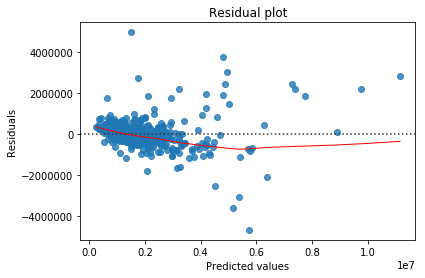

In [137]:
# seaborn residual plot
sns.residplot(fit_base.fittedvalues, train_df['Price_Sold'], lowess=True, line_kws={'color':'r', 'lw':1})
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals');

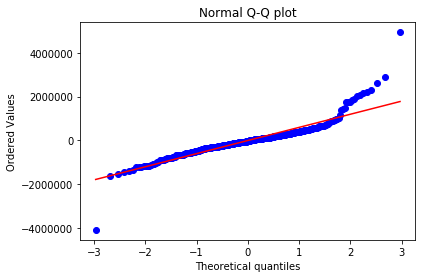

In [85]:
# QQ-plot on price sold >>>> use the logged price
stats.probplot(fit_base.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

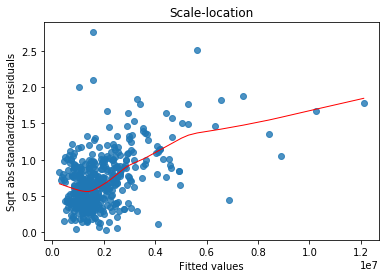

In [43]:
# Scale location plot
model_norm_resid = fit_base.get_influence().resid_studentized_internal
model_norm_resid_abs_sqrt = np.sqrt(np.abs(model_norm_resid))
sns.regplot(fit_base.fittedvalues, model_norm_resid_abs_sqrt, lowess=True, line_kws={'color':'r', 'lw':1})
plt.xlabel('Fitted values')
plt.ylabel('Sqrt abs standardized residuals')
plt.title('Scale-location');

## OLS - Model 1

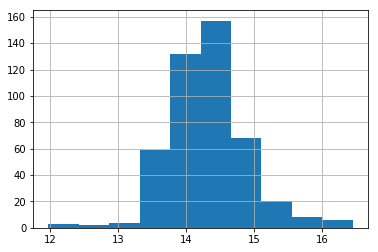

In [140]:
# Log Price_Sold
train_df['Log_Price_Sold'] = np.log(train_df.Price_Sold)
train_df.Log_Price_Sold.hist();

In [148]:
train_df['Bed_Bath_Interaction'] = train_df.Beds * train_df.Baths
X_train['Bed_Bath_Interaction'] = X_train.Beds * X_train.Baths

In [46]:
# Add interaction terms on Beds and Baths then take log on price sold
lsm = smf.ols('Log_Price_Sold ~ Beds + Baths + Bed_Bath_Interaction + Sqft + Year_Built + Heating + Cooling + Parking + HOA + Type_Condo + Type_Condo_Co_op + Type_Multi_Family + Type_Multi_Family_2_4_Unit + Type_Single_Family + Type_Single_Family_Residential + Type_Townhouse + Zipcode_94103 + Zipcode_94104 + Zipcode_94105 + Zipcode_94107 + Zipcode_94108 + Zipcode_94109 + Zipcode_94110 + Zipcode_94112 + Zipcode_94114 + Zipcode_94115 + Zipcode_94116 + Zipcode_94117 + Zipcode_94118 + Zipcode_94121 + Zipcode_94122 + Zipcode_94123 + Zipcode_94124 + Zipcode_94127 + Zipcode_94131 + Zipcode_94132 + Zipcode_94133 + Zipcode_94134 + Zipcode_94158', data=train_df)
fit_1 = lsm.fit()
fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Log_Price_Sold   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     31.45
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          1.10e-100
Time:                        07:37:47   Log-Likelihood:                -70.032
No. Observations:                 459   AIC:                             220.1
Df Residuals:                     419   BIC:                             385.2
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         14.3265      0.992     14.436      0.000      12.376      16.277
Beds                               0.1784      0.026      6.962      0.000       0.128       0.229
Baths                              0.2457      0.039      6.346      0.000       0.170       0.322
Bed_Bath_Interaction              -0.0660      0.008     -7.822      0.000      -0.083      -0.049
Sqft                               0.0004   3.15e-05     12.735      0.000       0.000       0.000
Year_Built                        -0.0007      0.000     -1.478      0.140      -0.002       0.000
Heating                           -0.0531      0.063     -0.844      0.399      -0.177       0.071
Cooling                            0.0142      0.063      0.227      0.821      -0.109       0.137
Parking                            0.0800      0.043      1.875      0.061      -0.004       0.164
HOA                               -0.0105      0.054     -0.193      0.847      -0.117       0.096
Type_Condo                         0.1103      0.177      0.625      0.533      -0.237       0.457
Type_Condo_Co_op                   0.0635      0.187      0.340      0.734      -0.304       0.431
Type_Multi_Family                  0.1923      0.223      0.863      0.389      -0.246       0.630
Type_Multi_Family_2_4_Unit        -0.2163      0.210     -1.031      0.303      -0.629       0.196
Type_Single_Family                 0.1882      0.179      1.050      0.294      -0.164       0.540
Type_Single_Family_Residential     0.2709      0.185      1.461      0.145      -0.093       0.635
Type_Townhouse                     0.0478      0.212      0.225      0.822      -0.369       0.465
Zipcode_94103                      0.1546      0.140      1.106      0.270      -0.120       0.430
Zipcode_94104                      0.1478      0.236      0.625      0.532      -0.317       0.612
Zipcode_94105                      0.1336      0.136      0.982      0.327      -0.134       0.401
Zipcode_94107                      0.0900      0.140      0.643      0.520      -0.185       0.365
Zipcode_94108                      0.1118      0.317      0.352      0.725      -0.512       0.736
Zipcode_94109                     -0.1783      0.129     -1.381      0.168      -0.432       0.076
Zipcode_94110                      0.0741      0.132      0.560      0.576      -0.186       0.334
Zipcode_94112                     -0.3114      0.152     -2.049      0.041      -0.610      -0.013
Zipcode_94114                      0.1140      0.117      0.973      0.331      -0.116       0.345
Zipcode_94115                      0.0367      0.122      0.301      0.764      -0.203       0.277
Zipcode_94116                     -0.1975      0.132     -1.498      0.135      -0.457       0.062
Zipcode_94117 

In [155]:
X_test['Bed_Bath_Interaction'] = X_test.Beds * X_test.Baths

test_set_pred_1 = fit_1.predict(X_test)
RMSE_1 = np.sqrt(np.mean((test_set_pred_1 - np.log(y_train))**2))
RMSE_1

0.752517222786886

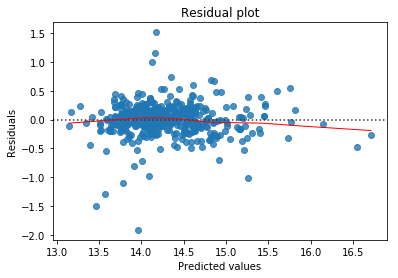

In [49]:
# seaborn residual plot
sns.residplot(fit_1.fittedvalues, train_df['Log_Price_Sold'], lowess=True, line_kws={'color':'r', 'lw':1})
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals');

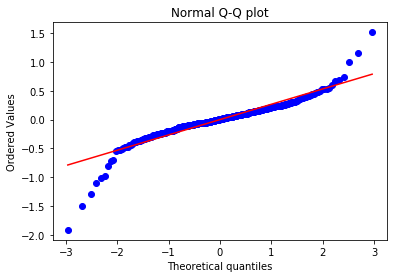

In [86]:
# QQ-plot on price sold >>>> use the logged price
stats.probplot(fit_1.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

## OLS - Model 2

In [52]:
# Higher AIC & high p-value, so stick with model 1
train_df['Heating_Cooling_Interaction'] = train_df.Heating * train_df.Cooling

In [97]:
# Drop Beds, Heating and take log on price sold
lsm = smf.ols('Log_Price_Sold ~ Beds + Baths + Bed_Bath_Interaction + Sqft + Year_Built + Heating + Cooling + Heating_Cooling_Interaction + Parking + HOA + Type_Condo + Type_Condo_Co_op + Type_Multi_Family + Type_Multi_Family_2_4_Unit + Type_Single_Family + Type_Single_Family_Residential + Type_Townhouse + Zipcode_94103 + Zipcode_94104 + Zipcode_94105 + Zipcode_94107 + Zipcode_94108 + Zipcode_94109 + Zipcode_94110 + Zipcode_94112 + Zipcode_94114 + Zipcode_94115 + Zipcode_94116 + Zipcode_94117 + Zipcode_94118 + Zipcode_94121 + Zipcode_94122 + Zipcode_94123 + Zipcode_94124 + Zipcode_94127 + Zipcode_94131 + Zipcode_94132 + Zipcode_94133 + Zipcode_94134 + Zipcode_94158', data=train_df)
fit_2 = lsm.fit()
fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Log_Price_Sold   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     30.77
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          2.62e-100
Time:                        11:38:00   Log-Likelihood:                -69.050
No. Observations:                 459   AIC:                             220.1
Df Residuals:                     418   BIC:                             389.4
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         14.2547      0.993     14.356      0.000      12.303      16.206
Beds                               0.1808      0.026      7.044      0.000       0.130       0.231
Baths                              0.2468      0.039      6.377      0.000       0.171       0.323
Bed_Bath_Interaction              -0.0663      0.008     -7.868      0.000      -0.083      -0.050
Sqft                               0.0004   3.15e-05     12.738      0.000       0.000       0.000
Year_Built                        -0.0007      0.000     -1.413      0.159      -0.002       0.000
Heating                           -0.0088      0.071     -0.123      0.902      -0.148       0.131
Cooling                            0.1619      0.127      1.277      0.202      -0.087       0.411
Heating_Cooling_Interaction       -0.1922      0.144     -1.339      0.181      -0.474       0.090
Parking                            0.0757      0.043      1.771      0.077      -0.008       0.160
HOA                               -0.0109      0.054     -0.201      0.841      -0.118       0.096
Type_Condo                         0.1168      0.177      0.662      0.508      -0.230       0.464
Type_Condo_Co_op                   0.0724      0.187      0.388      0.698      -0.295       0.440
Type_Multi_Family                  0.1945      0.223      0.873      0.383      -0.243       0.632
Type_Multi_Family_2_4_Unit        -0.2116      0.210     -1.009      0.313      -0.624       0.200
Type_Single_Family                 0.1897      0.179      1.060      0.290      -0.162       0.542
Type_Single_Family_Residential     0.2782      0.185      1.502      0.134      -0.086       0.642
Type_Townhouse                     0.0547      0.212      0.258      0.796      -0.362       0.472
Zipcode_94103                      0.1517      0.140      1.086      0.278      -0.123       0.426
Zipcode_94104                      0.1245      0.237      0.526      0.599      -0.341       0.590
Zipcode_94105                      0.1303      0.136      0.958      0.339      -0.137       0.398
Zipcode_94107                      0.0875      0.140      0.626      0.532      -0.187       0.362
Zipcode_94108                      0.1120      0.317      0.353      0.724      -0.511       0.735
Zipcode_94109                     -0.1772      0.129     -1.374      0.170      -0.431       0.076
Zipcode_94110                      0.0684      0.132      0.517      0.606      -0.192       0.328
Zipcode_94112                     -0.3135      0.152     -2.065      0.040      -0.612      -0.015
Zipcode_94114                      0.1073      0.117      0.916      0.360      -0.123       0.338
Zipcode_94115                      0.0362      0.122      0.297      0.767      -0.204       0.276
Zipcode_94116 

## OLS - Model 3 (Normalized Model 1)

In [199]:
# Normalize the features first
df_trans_model = preprocessing.normalize(train_df, axis=0)
df_trans_model = pd.DataFrame(df_trans_model, columns=train_df.columns)
df_trans_model['Log_Price_Sold'] = np.log(df_trans_model.Price_Sold)
y_trans_model = df_trans_model['Log_Price_Sold']
X_trans_model = df_trans_model.drop(['Log_Price_Sold', 'Price_Sold'], axis=1)

df_trans_model_test = preprocessing.normalize(test_df, axis=0)
df_trans_model_test = pd.DataFrame(df_trans_model_test, columns=test_df.columns)
df_trans_model_test['Log_Price_Sold'] = np.log(df_trans_model_test.Price_Sold)
y_trans_model_test = df_trans_model_test['Log_Price_Sold']
X_trans_model_test = df_trans_model_test.drop(['Log_Price_Sold', 'Price_Sold'], axis=1)

In [180]:
lsm = smf.ols('Log_Price_Sold ~ Beds + Baths + Bed_Bath_Interaction + Sqft + Year_Built + Heating + Cooling + Parking + HOA + Type_Condo + Type_Condo_Co_op + Type_Multi_Family + Type_Multi_Family_2_4_Unit + Type_Single_Family + Type_Single_Family_Residential + Type_Townhouse + Zipcode_94103 + Zipcode_94104 + Zipcode_94105 + Zipcode_94107 + Zipcode_94108 + Zipcode_94109 + Zipcode_94110 + Zipcode_94112 + Zipcode_94114 + Zipcode_94115 + Zipcode_94116 + Zipcode_94117 + Zipcode_94118 + Zipcode_94121 + Zipcode_94122 + Zipcode_94123 + Zipcode_94124 + Zipcode_94127 + Zipcode_94131 + Zipcode_94132 + Zipcode_94133 + Zipcode_94134 + Zipcode_94158', data=df_trans_model)
fit_1_norm = lsm.fit()
fit_1_norm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Log_Price_Sold   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     31.45
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          1.10e-100
Time:                        16:06:09   Log-Likelihood:                 2557.7
No. Observations:                 459   AIC:                            -5035.
Df Residuals:                     419   BIC:                            -4870.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0468      0.003     14.436      0.000       0.040       0.053
Beds                               0.0366      0.005      6.962      0.000       0.026       0.047
Baths                              0.0394      0.006      6.346      0.000       0.027       0.052
Bed_Bath_Interaction              -0.0420      0.005     -7.822      0.000      -0.053      -0.031
Sqft                               0.0552      0.004     12.735      0.000       0.047       0.064
Year_Built                        -0.0977      0.066     -1.478      0.140      -0.228       0.032
Heating                           -0.0020      0.002     -0.844      0.399      -0.007       0.003
Cooling                            0.0005      0.002      0.227      0.821      -0.004       0.005
Parking                            0.0036      0.002      1.875      0.061      -0.000       0.007
HOA                               -0.0005      0.002     -0.193      0.847      -0.005       0.004
Type_Condo                         0.0042      0.007      0.625      0.533      -0.009       0.017
Type_Condo_Co_op                   0.0019      0.006      0.340      0.734      -0.009       0.013
Type_Multi_Family                  0.0014      0.002      0.863      0.389      -0.002       0.005
Type_Multi_Family_2_4_Unit        -0.0022      0.002     -1.031      0.303      -0.006       0.002
Type_Single_Family                 0.0072      0.007      1.050      0.294      -0.006       0.021
Type_Single_Family_Residential     0.0076      0.005      1.461      0.145      -0.003       0.018
Type_Townhouse                     0.0005      0.002      0.225      0.822      -0.004       0.005
Zipcode_94103                      0.0017      0.002      1.106      0.270      -0.001       0.005
Zipcode_94104                      0.0007      0.001      0.625      0.532      -0.001       0.003
Zipcode_94105                      0.0016      0.002      0.982      0.327      -0.002       0.005
Zipcode_94107                      0.0010      0.002      0.643      0.520      -0.002       0.004
Zipcode_94108                      0.0004      0.001      0.352      0.725      -0.002       0.002
Zipcode_94109                     -0.0024      0.002     -1.381      0.168      -0.006       0.001
Zipcode_94110                      0.0010      0.002      0.560      0.576      -0.003       0.004
Zipcode_94112                     -0.0030      0.001     -2.049      0.041      -0.006      -0.000
Zipcode_94114                      0.0030      0.003      0.973      0.331      -0.003       0.009
Zipcode_94115                      0.0007      0.002      0.301      0.764      -0.004       0.005
Zipcode_94116                     -0.0030      0.002     -1.498      0.135      -0.007       0.001
Zipcode_94117 

In [184]:
# RMSE on train dataset
train_set_pred_1_norm = fit_1_norm.predict(X_trans_model)
RMSE_norm = np.sqrt(np.mean((train_set_pred_1_norm - y_trans_model)**2))
RMSE_norm

0.0009198257221109744

In [201]:
# RMSE on test dataset
test_set_pred_1_norm = fit_1_norm.predict(X_trans_model_test)
RMSE_norm = np.sqrt(np.mean((test_set_pred_1_norm - y_trans_model_test)**2))
RMSE_norm

2.910648590249947

In [205]:
y_predict_dollar = np.exp(test_set_pred_1_norm)
RMSE_reverse = np.sqrt(np.mean((y_predict_dollar - y_test)**2))
RMSE_reverse

1956088.7410739593

In [206]:
np.exp(14.40945)

1811109.1398250086

In [ ]:
# On average ur predicted value is x off from the acutual value

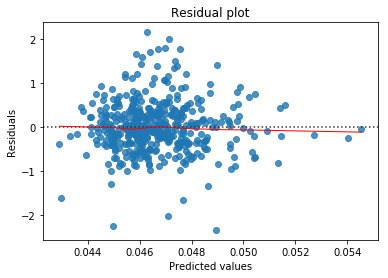

In [182]:
# seaborn residual plot
sns.residplot(fit_1_norm.fittedvalues, train_df['Log_Price_Sold'], lowess=True, line_kws={'color':'r', 'lw':1})
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals');

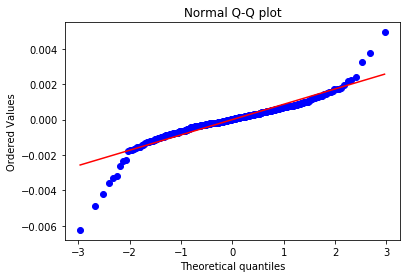

In [183]:
# QQ-plot on price sold >>>> use the logged price
stats.probplot(fit_1_norm.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

## Model 4 (Normalized based on the pvalue)

In [164]:
lsm = smf.ols('Log_Price_Sold ~ Beds + Baths + Bed_Bath_Interaction + Sqft + Parking + Zipcode_94103 + Zipcode_94104 + Zipcode_94105 + Zipcode_94107 + Zipcode_94108 + Zipcode_94109 + Zipcode_94110 + Zipcode_94112 + Zipcode_94114 + Zipcode_94115 + Zipcode_94116 + Zipcode_94117 + Zipcode_94118 + Zipcode_94121 + Zipcode_94122 + Zipcode_94123 + Zipcode_94124 + Zipcode_94127 + Zipcode_94131 + Zipcode_94132 + Zipcode_94133 + Zipcode_94134 + Zipcode_94158', data=df_trans_model)
fit_3_norm = lsm.fit()
fit_3_norm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Log_Price_Sold   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     40.21
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          6.39e-102
Time:                        14:34:20   Log-Likelihood:                 2538.9
No. Observations:                 459   AIC:                            -5020.
Df Residuals:                     430   BIC:                            -4900.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0422      0.000    106.926      0.000       0.041       0.043
Beds                     0.0366      0.005      7.040      0.000       0.026       0.047
Baths                    0.0447      0.006      7.393      0.000       0.033       0.057
Bed_Bath_Interaction    -0.0480      0.005     -8.967      0.000      -0.059      -0.038
Sqft                     0.0602      0.004     14.301      0.000       0.052       0.069
Parking                  0.0028      0.001      1.936      0.054   -4.31e-05       0.006
Zipcode_94103            0.0013      0.002      0.823      0.411      -0.002       0.004
Zipcode_94104            0.0005      0.001      0.433      0.665      -0.002       0.003
Zipcode_94105            0.0012      0.002      0.757      0.449      -0.002       0.004
Zipcode_94107            0.0007      0.002      0.452      0.651      -0.002       0.004
Zipcode_94108            0.0005      0.001      0.432      0.666      -0.002       0.003
Zipcode_94109           -0.0021      0.002     -1.214      0.226      -0.006       0.001
Zipcode_94110            0.0009      0.002      0.481      0.631      -0.003       0.004
Zipcode_94112           -0.0017      0.001     -1.171      0.242      -0.005       0.001
Zipcode_94114            0.0050      0.003      1.683      0.093      -0.001       0.011
Zipcode_94115            0.0014      0.002      0.616      0.538      -0.003       0.006
Zipcode_94116           -0.0007      0.002     -0.376      0.707      -0.004       0.003
Zipcode_94117            0.0020      0.002      0.806      0.421      -0.003       0.007
Zipcode_94118            0.0024      0.003      0.905      0.366      -0.003       0.008
Zipcode_94121           -0.0024      0.002     -0.997      0.319      -0.007       0.002
Zipcode_94122           -0.0022      0.003     -0.781      0.435      -0.008       0.003
Zipcode_94123            0.0052      0.002      2.396      0.017       0.001       0.009
Zipcode_94124           -0.0017      0.001     -1.517      0.130      -0.004       0.000
Zipcode_94127            0.0003      0.001      0.245      0.807      -0.002       0.003
Zipcode_94131          1.79e-05      0.002      0.010      0.992      -0.004       0.004
Zipcode_94132           -0.0021      0.002     -1.337      0.182      -0.005       0.001
Zipcode_94133            0.0016      0.001      1.438      0.151      -0.001       0.004
Zipcode_94134           -0.0030      0.001     -2.121      0.035      -0.006      -0.000
Zipcode_94158            0.0010      0.001      0.855      0.393      -0.001       0.003
==============================================================================
Omnibus:                      118.248   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1490.50

## Learning Curve

In [54]:
model = LinearRegression()
learning_curve(model, X_train, np.log(y_train), cv=4)

(array([ 34, 111, 189, 266, 344]),
 array([[0.96560142, 0.96695098, 0.96695098, 0.96695098],
        [0.80059259, 0.89835703, 0.89835703, 0.89835703],
        [0.70307749, 0.77590429, 0.84592036, 0.84592036],
        [0.70984438, 0.75400765, 0.77239377, 0.77972533],
        [0.72918268, 0.75960708, 0.77479476, 0.74040217]]),
 array([[-1.07295357,  0.310053  ,  0.24480826,  0.36663453],
        [ 0.65804437,  0.61403639,  0.57694683,  0.60477354],
        [ 0.76590168,  0.59886421,  0.61055007,  0.64197211],
        [ 0.78627931,  0.63871727,  0.61833368,  0.70462891],
        [ 0.79026922,  0.66244179,  0.63839553,  0.7229907 ]]))

In [55]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, np.log(y_train), cv=4)

In [56]:
train_scores

array([[0.96560142, 0.96695098, 0.96695098, 0.96695098],
       [0.80059259, 0.89835703, 0.89835703, 0.89835703],
       [0.70307749, 0.77590429, 0.84592036, 0.84592036],
       [0.70984438, 0.75400765, 0.77239377, 0.77972533],
       [0.72918268, 0.75960708, 0.77479476, 0.74040217]])

In [57]:
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

In [59]:
learn_df = pd.DataFrame({'train_size': train_sizes, 'train_score': ave_train_scores, 'test_score': ave_test_scores})
learn_df

,train_size,train_score,test_score
0,34,0.966614,-0.037864
1,111,0.873916,0.613450
2,189,0.792706,0.654322
3,266,0.753993,0.686990
4,344,0.750997,0.703524


(-1, 1)

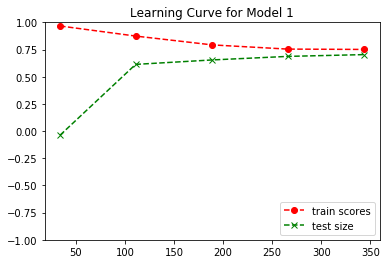

In [170]:
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'g--x', label='test size')
plt.legend(loc='lower right')
plt.title('Learning Curve for Model 1')
plt.ylim(-1,1)

## Predict using Model 1

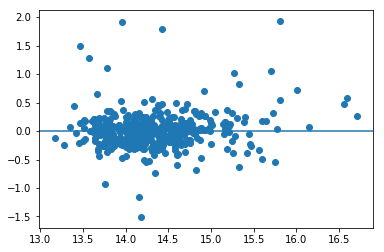

In [167]:
train_set_pred_1 = fit_1.predict(X_train)
plt.scatter(train_set_pred_1, train_set_pred_1 - np.log(y_train))
plt.gca().axhline(0)

## Linear Regression with sklearn (Model 1)

Log_Price_Sold ~ Beds + Baths + Bed_Bath_Interaction + Sqft + Year_Built + Heating + Cooling + Parking + HOA + Type_Condo + Type_Condo_Co_op + Type_Multi_Family + Type_Multi_Family_2_4_Unit + Type_Single_Family + Type_Single_Family_Residential + Type_Townhouse + Zipcode_94103 + Zipcode_94104 + Zipcode_94105 + Zipcode_94107 + Zipcode_94108 + Zipcode_94109 + Zipcode_94110 + Zipcode_94112 + Zipcode_94114 + Zipcode_94115 + Zipcode_94116 + Zipcode_94117 + Zipcode_94118 + Zipcode_94121 + Zipcode_94122 + Zipcode_94123 + Zipcode_94124 + Zipcode_94127 + Zipcode_94131 + Zipcode_94132 + Zipcode_94133 + Zipcode_94134 + Zipcode_94158

In [62]:
lr = LinearRegression()
lr.fit(X_train, np.log(y_train))
print(lr.score(X_train, np.log(y_train)), lr.score(X_test, np.log(y_test)))

0.7453988563855198 0.6057109562027079


In [63]:
# 10-fold cross-validation
scores = cross_val_score(lr, X, y, cv=10)#, scoring='neg_mean_squared_error')
print(scores)

[0.73641525 0.73336632 0.59114048 0.51448582 0.79194286 0.49214336
 0.63005534 0.77227508 0.70088416 0.80502303]


## Ridge & Lasso - Baseline Model

In [64]:
# Normalize the features first
df_trans = preprocessing.normalize(train_df, axis=0)

df_trans = pd.DataFrame(df_trans, columns=train_df.columns)

y_trans = df_trans['Log_Price_Sold']
X_trans = df_trans.drop(['Log_Price_Sold', 'Price_Sold'], axis=1)

No handles with labels found to put in legend.


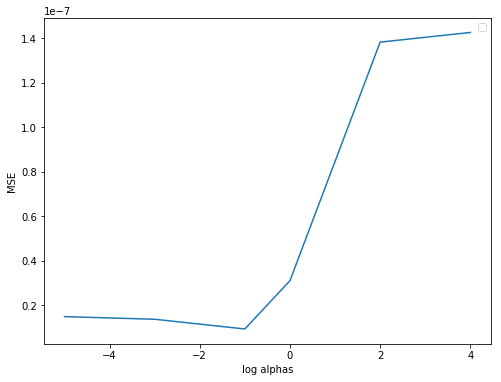

In [65]:
# Test, train, split option via Ridge 
alphas=[1e-5,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.25, random_state=42)

def make_estimator(est,alpha):
    est.alpha=alpha
    model = est.fit(X_train,y_train)
    mse=np.mean(y_test-model.predict(X_test))**2
    return mse
    
# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('log alphas')
plt.ylabel('MSE')
plt.show()

In [66]:
kf = KFold(n=len(X_trans), n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]

for train, test in kf:
    x_train=X_trans.iloc[train]
    y_train=y_trans.iloc[train]
    x_test=X_trans.iloc[test]
    y_test=y_trans.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

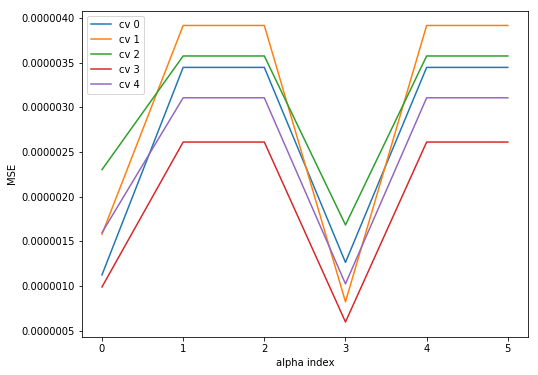

In [67]:
plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alpha index')
plt.ylabel('MSE')
plt.show()

In [68]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.25, random_state=42)

est = Lasso(alpha=0)
est.fit(X_train,y_train)
est.alpha


zipped=zip(X_trans.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:5]

[('Sqft', 0.055722119957847475),
 ('Baths', 0.040635359901548956),
 ('Beds', 0.0402407148854041),
 ('Type_Single_Family_Residential', 0.014015556644851053),
 ('Type_Single_Family', 0.013746494908633156)]

## Find the best regressor

In [69]:
models = {}
parameters = {}

models['linear_model'] = LinearRegression()
models['ridge_model'] = Ridge()
models['lasso_model'] = Lasso(alpha=.5)
models['robust_regression'] = SGDRegressor(loss='huber',max_iter=2000)
models['eps_insensitive'] = SGDRegressor(loss='epsilon_insensitive',max_iter=2000)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = cross_val_score(model, X_train, np.log(y_train), n_jobs=1)
    print('Model: '+ name)
    print("Score: " + str(np.mean(scores)))

Model: linear_model
Score: 0.6715848992316785
Model: ridge_model
Score: 0.37241757834746997
Model: lasso_model
Score: -0.0072320869211643934
Model: robust_regression
Score: 0.2182656332612243
Model: eps_insensitive
Score: -0.2042861739707044
Model: cart
Score: 0.41176753353755674
Model: extratrees
Score: 0.3737549748604742
Model: randomForest
Score: 0.5705024705690839
Model: adaboostedTrees
Score: 0.5506167109022716
Model: gradboostedTrees
Score: 0.6745007550295808
